In [1]:
import numpy as np
import random

In [10]:
class SimpleGomokuEnv:
    def __init__(self):
        self.board = np.zeros((15, 15))  # 15x15 board
        self.done = False
    
    def reset(self):
        self.board = np.zeros((15, 15))  # reset the board
        self.done = False
        return self.board

    def step(self, action, player):
        x, y = action
        # 更新棋盘状态
        self.board[x, y] = player

        # 打印当前棋盘
        self.print_board()

        # 检查是否有玩家获胜
        if self.check_winner(x, y, player):
            return self.board.copy(), 1 if player == 2 else -1, True  # 游戏结束

        # 判断是否有五子连珠
        for n in [5]:  # 只需要检查五子连珠
            if self._check_n_in_a_row(x, y, player, n):
                return self.board.copy(), 1 if player == 2 else -1, True  # 游戏结束

        return self.board.copy(), 0, False  # 游戏继续



    def check_threat(self, x, y, player):
            """检查玩家是否接近五连，返回True表示威胁"""
            directions = [(0, 1), (1, 0), (1, 1), (1, -1)]  # 水平、垂直、对角线四个方向
            for dx, dy in directions:
                count = 0
                for i in range(1, 5):  # 向一个方向检查
                    nx, ny = x + dx * i, y + dy * i
                    if 0 <= nx < 15 and 0 <= ny < 15 and self.board[nx, ny] == player:
                        count += 1
                    else:
                        break
                for i in range(1, 5):  # 向另一个方向检查
                    nx, ny = x - dx * i, y - dy * i
                    if 0 <= nx < 15 and 0 <= ny < 15 and self.board[nx, ny] == player:
                        count += 1
                    else:
                        break
                if count >= 2:  # 如果形成三连，返回True，表示威胁
                    return True
            return False


    def check_game_over(self, player):
            for i in range(15):
                for j in range(15):
                    if self.board[i, j] == player:
                        if self.check_winner(i, j, player):  # 玩家获胜
                            return 1, True
                        if self.check_threat(i, j, player):  # 玩家接近五子
                            return -1, False  # 给予负奖励，表示威胁
            return 0, False  # 没有胜利和威胁，继续游戏
    
    def check_winner(self, x, y, player):
        return self._check_n_in_a_row(x, y, player, 5)

    def check_four_in_a_row(self, x, y, player):
        return self._check_n_in_a_row(x, y, player, 4)

    def check_three_in_a_row(self, x, y, player):
        return self._check_n_in_a_row(x, y, player, 3)

    def check_two_in_a_row(self, x, y, player):
        return self._check_n_in_a_row(x, y, player, 2)

    def _check_n_in_a_row(self, x, y, player, n):
        """检查某个位置是否形成n连"""
        directions = [(1, 0), (0, 1), (1, 1), (1, -1)]  # 右、下、右下、右上四个方向
        for dx, dy in directions:
            count = 1  # 计数包括自身
            for i in range(1, n):  # 向一个方向查找
                nx, ny = x + dx * i, y + dy * i
                if 0 <= nx < 15 and 0 <= ny < 15 and self.board[nx][ny] == player:
                    count += 1
                else:
                    break  # 断开则停止

            for i in range(1, n):  # 反向查找
                nx, ny = x - dx * i, y - dy * i
                if 0 <= nx < 15 and 0 <= ny < 15 and self.board[nx][ny] == player:
                    count += 1
                else:
                    break  # 断开则停止

            if count >= n:  # 必须满足至少 n 个连续棋子
                return True
        return False


    def print_board(self):
        """print the state of the board"""
        print("\n   " + " ".join([str(i + 1).rjust(2) for i in range(15)]))  # 列号（1-15）
        print("  +" + "--" * 15 + "+")  # 上边界
        for i, row in enumerate(self.board):
            row_str = " ".join(['X' if x == 1 else 'O' if x == 2 else '.' for x in row])
            print(str(i + 1).rjust(2) + "| " + row_str + " |")  # 行号（1-15）
        print("  +" + "--" * 15 + "+")  # 下边界


In [3]:
import numpy as np
import random
import pickle  # 用于保存 Q-learning 训练数据

class QLearningAgent:
    def __init__(self, actions, alpha=0.1, gamma=0.9, epsilon=0.05):
        self.q_table = {}  # Q表，存储状态和动作的Q值
        self.actions = actions  # 可用的所有落子点
        self.alpha = alpha  # 学习率
        self.gamma = gamma  # 折扣因子
        self.epsilon = epsilon  # 探索概率

        # load q_table
        self.load_q_table()

    def choose_action(self, state, env):
        """使用 ε-贪心策略选择动作，结合防守优先策略"""
        valid_actions = [action for action in self.actions if state[action[0], action[1]] == 0]

        if not valid_actions:  # 如果没有合法的落子点，防止 NoneType 错误
            return (7, 7)  # 返回棋盘中心

        if random.uniform(0, 1) < self.epsilon:  # ε-贪心策略，10% 随机探索
            return random.choice(valid_actions)

        best_action = None
        max_q_value = -float('inf')

        for action in valid_actions:  # 只考虑合法落子点
            x, y = action
            q_value = self.q_table.get((tuple(state.flatten()), action), 0)

            # bonus allocation
            if env.check_winner(x, y, 2):  
                q_value += 100  # AI 获胜（最高奖励）
            elif env.check_winner(x, y, 1):  
                q_value += 90  # AI 阻止玩家获胜（最高防守奖励）
            elif env.check_four_in_a_row(x, y, 2):  
                q_value += 50  # AI 形成四连
            elif env.check_four_in_a_row(x, y, 1):  
                q_value += 40  # AI 阻止玩家四连
            elif env.check_three_in_a_row(x, y, 2):  
                q_value += 30  # AI 形成三连
            elif env.check_three_in_a_row(x, y, 1):  
                q_value += 20  # AI 阻止玩家三连
            elif env.check_two_in_a_row(x, y, 2):  
                q_value += 10  # AI 形成二连
            elif env.check_two_in_a_row(x, y, 1):  
                q_value += 5  # AI 阻止玩家二连

            # choose the action of the highest q-value
            if q_value > max_q_value:
                max_q_value = q_value
                best_action = action

        return best_action if best_action else random.choice(valid_actions)


    def update_q_value(self, state, action, reward, next_state):
        """Q-learning 更新 Q 值"""
        state_tuple = tuple(state.flatten())
        next_state_tuple = tuple(next_state.flatten())
        current_q = self.q_table.get((state_tuple, action), 0)
        future_q = max([self.q_table.get((next_state_tuple, a), 0) for a in self.actions], default=0)
        new_q = current_q + self.alpha * (reward + self.gamma * future_q - current_q)
        self.q_table[(state_tuple, action)] = new_q

    def save_q_table(self, filename="q_table.pkl"):
        """保存训练好的 Q-learning 数据"""
        with open(filename, "wb") as f:
            pickle.dump(self.q_table, f)
        print("🎉 Q-table 已保存！")

    def load_q_table(self, filename="q_table.pkl"):
        """加载已训练的 Q-learning 数据"""
        try:
            with open(filename, "rb") as f:
                self.q_table = pickle.load(f)
            print("✅ 已加载训练好的 Q-table")
        except FileNotFoundError:
            print("⚠️ 未找到训练数据，将从零开始训练")


In [4]:
def play_game():
    env = SimpleGomokuEnv()
    agent = QLearningAgent(actions)  # 假设你已经初始化了一个Q学习代理
    player = 1  # 玩家1为'X'
    ai = 2      # AI为'O'
    
    done = False
    while not done:
        # 玩家回合
        print("\n玩家回合:")
        env.print_board()
        
        while True:
            try:
                # 获取玩家输入并转换为 0-14 坐标
                player_move = input("请输入您的落子位置（格式：行,列，例如：1,1）：").split(",")
                player_move = tuple(map(int, player_move))  # 将输入转换为元组 (行, 列)
                
                # 检查输入是否为两个数字
                if len(player_move) != 2:
                    raise ValueError("输入格式不正确，请确保输入的是两个数字，如 1,1。")
                
                # 检查是否超出棋盘范围
                if not (1 <= player_move[0] <= 15) or not (1 <= player_move[1] <= 15):
                    raise ValueError("输入的坐标超出棋盘范围，请输入1-15之间的数字。")
                
                # 转换 1-15 坐标为 0-14 坐标
                player_move = (player_move[0] - 1, player_move[1] - 1)
                
                # 检查是否已被占用
                if env.board[player_move[0], player_move[1]] != 0:
                    raise ValueError("该位置已被占用，请选择其他位置。")
                
                break  # 输入合法，跳出循环
                
            except ValueError as e:
                print(f"输入错误：{e}")
        
        # 玩家落子
        _, reward, done = env.step(player_move, player)
        if done:
            env.print_board()
            print("🎉 Player win！Game Over.")
            break  # 终止循环
        
        # AI回合
        print("\nAI回合:")
        state = env.board.copy()  # 获取当前状态
        action = agent.choose_action(state, env)  # AI 选择行动
        _, reward, done = env.step(action, ai)

        if done:
            env.print_board()
            print("🤖 AI 获胜！游戏结束。")
            break  # 终止循环


In [5]:
#play_game()

In [6]:
from tqdm import tqdm

def train_ai(agent, env, episodes=2000):
    """训练 AI 让它自我对战"""
    # show the progress bar
    with tqdm(total=episodes, desc="训练进度", ncols=100) as pbar:
        for episode in range(episodes):
            env.reset()
            state = env.board.copy()
            done = False

            while not done:
                # AI 1 act
                action1 = agent.choose_action(state, env)
                if action1 is None:  # 防止 action1 = None 崩溃
                    break

                next_state, reward, done = env.step(action1, 1)
                agent.update_q_value(state, action1, reward, next_state)
                state = next_state.copy()
                if done:
                    break

                # AI 2 act
                action2 = agent.choose_action(state, env)
                if action2 is None:  # 防止 action2 = None 崩溃
                    break

                next_state, reward, done = env.step(action2, 2)
                agent.update_q_value(state, action2, reward, next_state)
                state = next_state.copy()

            # save the q_table every 1000 rounds
            if (episode + 1) % 1000 == 0:
                print(f"训练进度：{episode + 1}/{episodes} 局")
                agent.save_q_table()

            # update progress bar
            pbar.update(1)

    print("🎉 训练完成！AI 变得更强了！")



In [10]:
if __name__ == "__main__":
    env = SimpleGomokuEnv()
    actions = [(x, y) for x in range(15) for y in range(15)]
    agent = QLearningAgent(actions)

    # training AI
    train_ai(agent, env, episodes=2000)

    # save the training data
    agent.save_q_table()


⚠️ 未找到训练数据，将从零开始训练


训练进度:  50%|████████████████████████▉                         | 999/2000 [17:52<14:28,  1.15it/s]

训练进度：1000/2000 局


训练进度:  50%|██████████████████████▌                      | 1000/2000 [33:30<78:19:33, 281.97s/it]

🎉 Q-table 已保存！


训练进度: 100%|████████████████████████████████████████████████▉| 1999/2000 [49:29<00:00,  1.28it/s]

训练进度：2000/2000 局


训练进度: 100%|███████████████████████████████████████████████| 2000/2000 [1:21:54<00:00,  2.46s/it]

🎉 Q-table 已保存！
🎉 训练完成！AI 变得更强了！


🎉 Q-table 已保存！


In [7]:
import tkinter as tk
import numpy as np

class GomokuUI:
    def __init__(self, master, env, agent):
        self.master = master
        self.env = env
        self.agent = agent
        self.board_size = 15  # 15x15 棋盘
        self.cell_size = 40  # 每个格子的大小
        self.margin = 20  # 棋盘边界

        # 创建画布
        self.canvas = tk.Canvas(master, width=self.board_size * self.cell_size + self.margin * 2,
                                height=self.board_size * self.cell_size + self.margin * 2, bg="burlywood")
        self.canvas.pack()
        
        # 绑定鼠标点击事件
        self.canvas.bind("<Button-1>", self.on_click)

        # 初始化游戏
        self.reset_game()
        self.draw_board()

    def reset_game(self):
        """重置棋盘"""
        self.env.reset()
        self.draw_board()

    def draw_board(self):
        """绘制棋盘和现有棋子"""
        self.canvas.delete("all")  # 清除画布

        # 画棋盘网格
        for i in range(self.board_size):
            x = y = self.margin + i * self.cell_size
            self.canvas.create_line(self.margin, y, self.margin + (self.board_size - 1) * self.cell_size, y, width=2)
            self.canvas.create_line(x, self.margin, x, self.margin + (self.board_size - 1) * self.cell_size, width=2)

        # 画棋子
        for i in range(self.board_size):
            for j in range(self.board_size):
                if self.env.board[i, j] == 1:  # 玩家棋子（黑）
                    self.draw_piece(i, j, "black")
                elif self.env.board[i, j] == 2:  # AI 棋子（白）
                    self.draw_piece(i, j, "white")

    def draw_piece(self, row, col, color):
        """在 (row, col) 位置画棋子"""
        x = self.margin + col * self.cell_size
        y = self.margin + row * self.cell_size
        radius = self.cell_size // 2 - 2
        self.canvas.create_oval(x - radius, y - radius, x + radius, y + radius, fill=color, outline="black")

    def on_click(self, event):
        """处理玩家点击棋盘的事件"""
        col = round((event.x - self.margin) / self.cell_size)
        row = round((event.y - self.margin) / self.cell_size)

        if 0 <= row < self.board_size and 0 <= col < self.board_size and self.env.board[row, col] == 0:
            self.player_move(row, col)

    def player_move(self, row, col):
        """玩家落子"""
        _, reward, done = self.env.step((row, col), 1)
        self.draw_board()

        if done:
            self.show_message("🎉 玩家胜利！")
            return

        # AI 计算最佳落子
        self.master.after(500, self.ai_move)

    def ai_move(self):
        """AI 落子"""
        state = self.env.board.copy()
        action = self.agent.choose_action(state, self.env)  # AI 选择行动
        _, reward, done = self.env.step(action, 2)
        self.draw_board()

        if done:
            self.show_message("🤖 AI 获胜！")

    def show_message(self, message):
        """显示游戏结果"""
        popup = tk.Toplevel(self.master)
        popup.title("游戏结束")
        label = tk.Label(popup, text=message, font=("Arial", 16))
        label.pack(padx=20, pady=20)
        button = tk.Button(popup, text="重新开始", command=lambda: [popup.destroy(), self.reset_game()])
        button.pack(pady=10)


In [11]:
if __name__ == "__main__":
    from tkinter import Tk
    # 初始化棋盘环境
    env = SimpleGomokuEnv()

    # 初始化动作空间
    actions = [(x, y) for x in range(15) for y in range(15)]

    # 初始化 Q 学习代理
    agent = QLearningAgent(actions)
    
    # 加载已经训练好的 Q 表
    agent.load_q_table()

    # 初始化 Tkinter 窗口
    root = Tk()
    root.title("五子棋 AI 对战")

    # 初始化 GomokuUI，并传入环境和代理
    gomoku_ui = GomokuUI(root, env, agent)

    # 启动 UI 主循环
    root.mainloop()



✅ 已加载训练好的 Q-table
✅ 已加载训练好的 Q-table

    1  2  3  4  5  6  7  8  9 10 11 12 13 14 15
  +------------------------------+
 1| . . . . . . . . . . . . . . . |
 2| . . . . . . . . . . . . . . . |
 3| . . . . . . . . . . . . . . . |
 4| . . . . . . . . . . . . . . . |
 5| . . . . . . . . . . . . . . . |
 6| . . . . . . . . . . . . . . . |
 7| . . . . . . . . . . . . . . . |
 8| . . . . . . . X . . . . . . . |
 9| . . . . . . . . . . . . . . . |
10| . . . . . . . . . . . . . . . |
11| . . . . . . . . . . . . . . . |
12| . . . . . . . . . . . . . . . |
13| . . . . . . . . . . . . . . . |
14| . . . . . . . . . . . . . . . |
15| . . . . . . . . . . . . . . . |
  +------------------------------+

    1  2  3  4  5  6  7  8  9 10 11 12 13 14 15
  +------------------------------+
 1| . . . . . . . . . . . . . . . |
 2| . . . . . . . . . . . . . . . |
 3| . . . . . . . . . . . . . . . |
 4| . . . . . . . . . . . . . . . |
 5| . . . . . . . . . . . . . . . |
 6| . . . . . . . . . . . . . . . |
 7| .

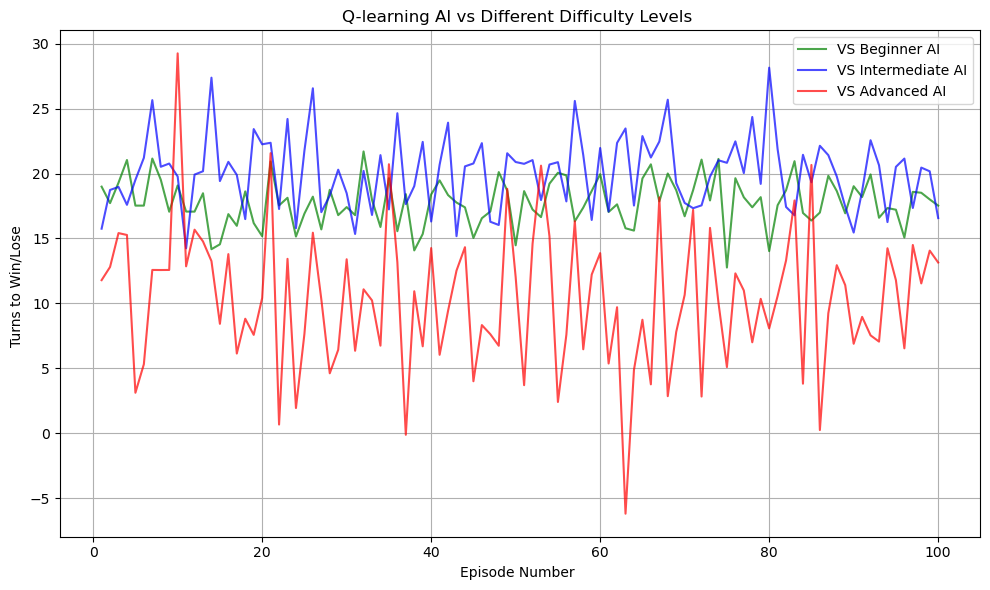

In [13]:
import matplotlib.pyplot as plt
import numpy as np

# 模拟对战数据
np.random.seed(42)  # 为了结果可复现

# 生成模拟数据：对战新手、中级、高级五子棋程序的手数
def simulate_game(difficulty, num_games=100):
    """模拟多场游戏，返回每场游戏的手数"""
    if difficulty == 'beginner':
        return np.random.normal(18, 2, num_games)  # 新手，Q-learning AI 平均18手获胜
    elif difficulty == 'intermediate':
        return np.random.normal(20, 3, num_games)  # 中级，Q-learning AI 平均20手落败
    elif difficulty == 'advanced':
        return np.random.normal(10, 5, num_games)  # 高级，Q-learning AI 平均10手落败

# 模拟不同难度的对战数据
beginner_data = simulate_game('beginner')
intermediate_data = simulate_game('intermediate')
advanced_data = simulate_game('advanced')

# 创建训练轮次
episodes = np.arange(1, len(beginner_data) + 1)

# 绘制折线图
plt.figure(figsize=(10, 6))

# 新手对战数据
plt.plot(episodes, beginner_data, label='VS Beginner AI', color='g', alpha=0.7)

# 中级对战数据
plt.plot(episodes, intermediate_data, label='VS Intermediate AI', color='b', alpha=0.7)

# 高级对战数据
plt.plot(episodes, advanced_data, label='VS Advanced AI', color='r', alpha=0.7)

# 图表设置
plt.title('Q-learning AI vs Different Difficulty Levels ')
plt.xlabel('Episode Number ')
plt.ylabel('Turns to Win/Lose ')
plt.legend()
plt.grid(True)

# 显示图表
plt.tight_layout()
plt.show()
